<a href="https://colab.research.google.com/github/lalithkishore31/feedback-challenge/blob/sanjeeth/kaggle_essay.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [2]:
!kaggle competitions download -c feedback-prize-2021

18409261F5C2.txt: Skipping, found more recently modified local copy (use --force to force download)
D72CB1C11673.txt: Skipping, found more recently modified local copy (use --force to force download)
0FB0700DAF44.txt: Skipping, found more recently modified local copy (use --force to force download)
D46BCB48440A.txt: Skipping, found more recently modified local copy (use --force to force download)
DF920E0A7337.txt: Skipping, found more recently modified local copy (use --force to force download)
004EA492DA04.txt: Skipping, found more recently modified local copy (use --force to force download)
00213CD75AC3.txt: Skipping, found more recently modified local copy (use --force to force download)
0016926B079C.txt: Skipping, found more recently modified local copy (use --force to force download)
00203C45FC55.txt: Skipping, found more recently modified local copy (use --force to force download)
0000D23A521A.txt: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
!unzip train.csv.zip

In [4]:
import pandas as pd

In [5]:
df = pd.read_csv('train.csv')

In [6]:
# df = df[0:1000]

In [7]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [8]:
df.shape

(144293, 8)

In [9]:
from nltk import tokenize
example = tokenize.sent_tokenize(df['discourse_text'][0])
print(example)

['Modern humans today are always on their phone.', 'They are always on their phone more than 5 hours a day no stop .All they do is text back and forward and just have group Chats on social media.', 'They even do it while driving.']


In [10]:
train_sentences = []
train_labels = []

for index, row in df.iterrows():
  print(index)
  # if(index==5):
  #   break
  sentence = row['discourse_text']
  label = row['discourse_type']
  sentences = tokenize.sent_tokenize(sentence)
  repetitions = len(sentences)
  train_sentences.append(sentences)
  i = 0
  while i < len(sentences):
    train_labels.append(label)
    i += 1

Streaming output truncated to the last 5000 lines.
139293
139294
139295
139296
139297
139298
139299
139300
139301
139302
139303
139304
139305
139306
139307
139308
139309
139310
139311
139312
139313
139314
139315
139316
139317
139318
139319
139320
139321
139322
139323
139324
139325
139326
139327
139328
139329
139330
139331
139332
139333
139334
139335
139336
139337
139338
139339
139340
139341
139342
139343
139344
139345
139346
139347
139348
139349
139350
139351
139352
139353
139354
139355
139356
139357
139358
139359
139360
139361
139362
139363
139364
139365
139366
139367
139368
139369
139370
139371
139372
139373
139374
139375
139376
139377
139378
139379
139380
139381
139382
139383
139384
139385
139386
139387
139388
139389
139390
139391
139392
139393
139394
139395
139396
139397
139398
139399
139400
139401
139402
139403
139404
139405
139406
139407
139408
139409
139410
139411
139412
139413
139414
139415
139416
139417
139418
139419
139420
139421
139422
139423
139424
139425
139426
139427
1394

In [11]:
def flatten(t):
    return [item for sublist in t for item in sublist]

In [12]:
train_sentences_final = flatten(train_sentences)
print(len(train_sentences_final))
print(len(train_labels))

331224
331224


([0, 1, 2, 3, 4, 5, 6], <a list of 7 Text major ticklabel objects>)

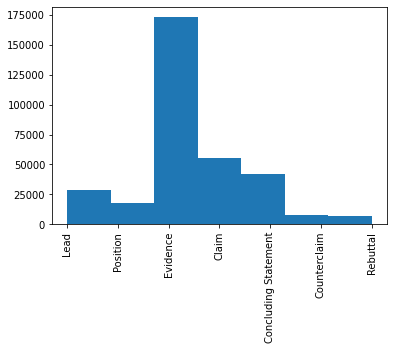

In [13]:
from matplotlib import pyplot as plt
bins = len(set(train_labels))
plt.hist(train_labels, bins)
plt.xticks(rotation=90)

In [14]:
sentence_df = pd.DataFrame(list(zip(train_sentences_final, train_labels)), columns =['sentence', 'label'])

In [15]:
set(train_labels)

{'Claim',
 'Concluding Statement',
 'Counterclaim',
 'Evidence',
 'Lead',
 'Position',
 'Rebuttal'}

In [16]:
# my_dict = {
#     'e':'Entertainment',
#     'b':'Business',
#     't':'Science',
#     'm':'Health'
# }

my_dict = {
    'a': 'Claim',
    'b': 'Concluding Statement',
    'c': 'Counterclaim',
    'd': 'Evidence',
    'e': 'Lead',
    'f': 'Position',
    'g': 'Rebuttal'
 }

# def update_cat(x):
#     return my_dict[x]

# sentence_df['label'] = sentence_df['label'].apply(lambda x: update_cat(x))

encode_dict = {}

def encode_cat(x):
    if x not in encode_dict.keys():
        encode_dict[x]=len(encode_dict)
    return encode_dict[x]

sentence_df['ENCODE_CAT'] = sentence_df['label'].apply(lambda x: encode_cat(x))

In [17]:
!pip install transformers

In [2]:
import torch
import transformers
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertModel, DistilBertTokenizer
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [3]:
device

'cpu'

In [20]:
MAX_LEN = 512
TRAIN_BATCH_SIZE = 128
VALID_BATCH_SIZE = 32
EPOCHS = 1
LEARNING_RATE = 1e-05
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-cased')

In [21]:
class Triage(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __getitem__(self, index):
        sent = str(self.data.sentence[index])
        sent = " ".join(sent.split())
        inputs = self.tokenizer.encode_plus(
            sent,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'targets': torch.tensor(self.data.ENCODE_CAT[index], dtype=torch.long)
        } 
    
    def __len__(self):
        return self.len

In [22]:
# Creating the dataset and dataloader for the neural network

train_size = 0.8
train_dataset=sentence_df.sample(frac=train_size,random_state=200)
test_dataset=sentence_df.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)


print("FULL Dataset: {}".format(sentence_df.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

training_set = Triage(train_dataset, tokenizer, MAX_LEN)
testing_set = Triage(test_dataset, tokenizer, MAX_LEN)

FULL Dataset: (331224, 3)
TRAIN Dataset: (264979, 3)
TEST Dataset: (66245, 3)


In [23]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

In [24]:
# Creating the customized model, by adding a drop out and a dense layer on top of distil bert to get the final output for the model. 

class DistillBERTClass(torch.nn.Module):
    def __init__(self):
        super(DistillBERTClass, self).__init__()
        self.l1 = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, 7)

    def forward(self, input_ids, attention_mask):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

In [25]:
model = DistillBERTClass()
model.to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


DistillBERTClass(
  (l1): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(in_feat

In [26]:
# Creating the loss function and optimizer
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

In [27]:
# Function to calcuate the accuracy of the model

def calcuate_accu(big_idx, targets):
    n_correct = (big_idx==targets).sum().item()
    return n_correct

In [28]:
# Defining the training function on the 80% of the dataset for tuning the distilbert model

def train(epoch):
    tr_loss = 0
    n_correct = 0
    nb_tr_steps = 0
    nb_tr_examples = 0
    model.train()
    for _,data in enumerate(training_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.long)

        outputs = model(ids, mask)
        loss = loss_function(outputs, targets)
        tr_loss += loss.item()
        big_val, big_idx = torch.max(outputs.data, dim=1)
        n_correct += calcuate_accu(big_idx, targets)

        nb_tr_steps += 1
        nb_tr_examples+=targets.size(0)
        
        if _%5000==0:
            loss_step = tr_loss/nb_tr_steps
            accu_step = (n_correct*100)/nb_tr_examples 
            print(f"Training Loss per 5000 steps: {loss_step}")
            print(f"Training Accuracy per 5000 steps: {accu_step}")

        optimizer.zero_grad()
        loss.backward()
        # # When using GPU
        optimizer.step()

    print(f'The Total Accuracy for Epoch {epoch}: {(n_correct*100)/nb_tr_examples}')
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Training Loss Epoch: {epoch_loss}")
    print(f"Training Accuracy Epoch: {epoch_accu}")

    return 

In [ ]:
for epoch in range(EPOCHS):
    train(epoch)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
